## Metro Transport Company Analysis

### Introduction
Metro Transport Company has asked me to analyze data on their current bus lines to help improve operations. The data includes details on routes, schedules, and passengers.

My analysis aims to:

* Identify any problematic bus lines that may need to be shut down or improved
* Find the lowest revenue bus line to consider changes to improve profitability
* Analyze revenue patterns across days of the week to optimize schedules

## Data Understanding
The data is in 3 tables:
### 1. Routes Table:
* **bus_num** - the number of the bus line
* **intercity** - does the bus line start in one city and end another (y = yes / n = no)
* **type**- the type of bus service (express/ regular)
* **num_stops** - the number of stops made by the bus
* **fare** - the cost of a single bus ticket (the price does not change depending on where the passenger gets on/off the bus)


In [1]:
import pandas as pd
#Reading the routes sheet from the excel file
df_routes = pd.read_excel('Assessment_Data_Sababi.xlsx', sheet_name='Routes')
df_routes.head()

,bus_num,intercity,type,num_stops,fare
0,1,N,regular,17,3.5
1,2,N,regular,34,3.5
2,3,N,express,10,5.0
3,5,Y,express,15,12.5
4,8,Y,regular,45,10.0



FOR EXAMPLE: Bus line 63 is a regular bus route with 34 stops and does not cross city lines. The fare of bus line 63 is $3.50.


In [2]:
# Getting Bus line 63 info
df_routes[df_routes['bus_num'] == 63]

,bus_num,intercity,type,num_stops,fare
18,63,N,regular,34,3.5


### 2. Times Table:
* **time_of_week** - is it a weekday (Mon - Fri) or weekend day (Sat - Sun)
* **bus_num** - the number of the bus line
* **first_bus** - the departure time of the first bus of the day (same in both directions)
* **last_bus** - the departure time of the last bus of the day (same in both directions)
* **frequency** - the number of times the bus completes its full route each day.


In [3]:
#Reading the Times sheet from the dataset
df_times = pd.read_excel('Assessment_Data_Sababi.xlsx', sheet_name='Times')
df_times.head()

,time_of_week,bus_num,first_bus,last_bus,frequency
0,weekday,1,05:00:00,22:30:00,10
1,weekday,2,05:30:00,22:45:00,15
2,weekday,3,05:15:00,22:30:00,9
3,weekday,5,06:00:00,23:00:00,20
4,weekday,8,06:25:00,23:05:00,40



FOR EXAMPLE: On weekend, bus line 63 operates between 6:20 AM and 9:30 PM. During that period, it completes its route 35 times. 


In [4]:
# Getting bus line 63 and the day being weekend info
df_times[(df_times['bus_num'] ==63) & (df_times['time_of_week']=='weekend')]

,time_of_week,bus_num,first_bus,last_bus,frequency
45,weekend,63,06:20:00,21:30:00,35


### 3. Passengers Table:
* **day** - the day of the week
* **bus_num** - the number of the bus line
* **average_num_passengers** - the average number of passengers per route.


In [5]:
#Reading the passengers' sheet from the dataset
df_passengers = pd.read_excel('Assessment_Data_Sababi.xlsx', sheet_name='Passengers')
df_passengers.head()

,day,bus_num,average_num_passengers
0,Monday,1,23
1,Tuesday,1,21
2,Wednesday,1,36
3,Thursday,1,27
4,Friday,1,21



FOR EXAMPLE: Bus line 63 averages 15 passengers on Wednesdays and 38 passengers on Saturdays. 

In [6]:
# Getting bus line 63 info, the day being Wednesday and Saturday
days = ['Wednesday', 'Saturday']
df_passengers[(df_passengers['bus_num'] == 63) & (df_passengers['day'].isin(days))]

,day,bus_num,average_num_passengers
128,Wednesday,63,15
131,Saturday,63,38


## Data Preparation
The tables were joined by **bus_num** to create a combined DataFrame for analysis.

In [7]:
# Joining the DataFrames and creating a new DataFrame
# The unique identifier is the 'bus_num'
df = df_routes.merge(df_times, on='bus_num')
df = df.merge(df_passengers, on='bus_num')
df.head()

,bus_num,intercity,type,num_stops,fare,time_of_week,first_bus,last_bus,frequency,day,average_num_passengers
0,1,N,regular,17,3.5,weekday,05:00:00,22:30:00,10,Monday,23
1,1,N,regular,17,3.5,weekday,05:00:00,22:30:00,10,Tuesday,21
2,1,N,regular,17,3.5,weekday,05:00:00,22:30:00,10,Wednesday,36
3,1,N,regular,17,3.5,weekday,05:00:00,22:30:00,10,Thursday,27
4,1,N,regular,17,3.5,weekday,05:00:00,22:30:00,10,Friday,21


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bus_num                 378 non-null    int64  
 1   intercity               378 non-null    object 
 2   type                    378 non-null    object 
 3   num_stops               378 non-null    int64  
 4   fare                    378 non-null    float64
 5   time_of_week            378 non-null    object 
 6   first_bus               378 non-null    object 
 7   last_bus                378 non-null    object 
 8   frequency               378 non-null    int64  
 9   day                     378 non-null    object 
 10  average_num_passengers  378 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 32.6+ KB


The combined data has 378 rows and 11 columns with no missing or duplicate values.

In [9]:
# Confirming that the dataset has no duplicates
len(df[df.duplicated()])

0

## Exploratory Data Analysis (EDA)
To improve operations, the company considers discontinuing some weekend bus lines if operational costs exceed 50% of weekend revenue. On average, it costs the company $2 per stop on each route.

**Identifying Problematic Bus Lines**

In [10]:

# Calculating operational costs for each bus on weekends
df['operational_costs'] = df["num_stops"] * df["frequency"] * 2

# Calculate total revenue on weekends
df['total_revenue'] = df['average_num_passengers'] * df['fare'] * df['frequency']

## Flagging problematic bus lines
df["problematic"] = df['operational_costs'] > 0.5 * df['total_revenue']

# Keeping only the first occurrence of each unique bus line
problematic_df = df[df["problematic"]].drop_duplicates(subset='bus_num')

# Counting the number of problematic bus lines
num_problematic_lines = len(problematic_df)

print("Number of problematic bus lines:", num_problematic_lines)


Number of problematic bus lines: 13


In [11]:
# Getting the 'bus_num' that were flagged as problematic
problematic_df['bus_num'].to_list()

[1, 2, 8, 10, 14, 18, 22, 28, 35, 58, 63, 68, 85]

To find problematic bus lines, I calculated the weekend operational costs and revenue for each route.

Operational costs per route were calculated as:

*num_stops * frequency * $2*

Revenue per route was calculated as:

*average_num_passengers * fare * frequency*

Any bus line where weekend operational costs exceeded 50% of revenue was flagged as **problematic**.

**13 bus lines** were identified as problematic using this criteria. These may be candidates for reductions or improvements.

**Lowest Revenue Bus Line**

To find the lowest revenue bus line, I calculated the total weekly revenue for each route.

In [12]:
# Calculate daily revenue
df['daily_revenue'] = df['average_num_passengers'] * df['fare'] * df['frequency']

# Groupping by bus_num and calculating total weekly revenue
weekly_revenue_df = df.groupby('bus_num')['daily_revenue'].sum().reset_index()

# Calculating average weekly revenue
weekly_revenue_df['average_weekly_revenue'] = weekly_revenue_df['daily_revenue'] / 7

# Finding the bus line with the lowest average weekly revenue
lowest_revenue_bus_line = weekly_revenue_df.loc[weekly_revenue_df['average_weekly_revenue'].idxmin()]

print("Bus line with the lowest average weekly revenue:")
print(lowest_revenue_bus_line[['bus_num', 'average_weekly_revenue']])


Bus line with the lowest average weekly revenue:
bus_num                      1.0
average_weekly_revenue    1660.0
Name: 0, dtype: float64


**Bus line 1** had the lowest average weekly revenue of **$1660**. This line could be improved to generate more profit.

**Revenue Analysis by Day**

A bar chart was created to analyze revenue by day of the week:

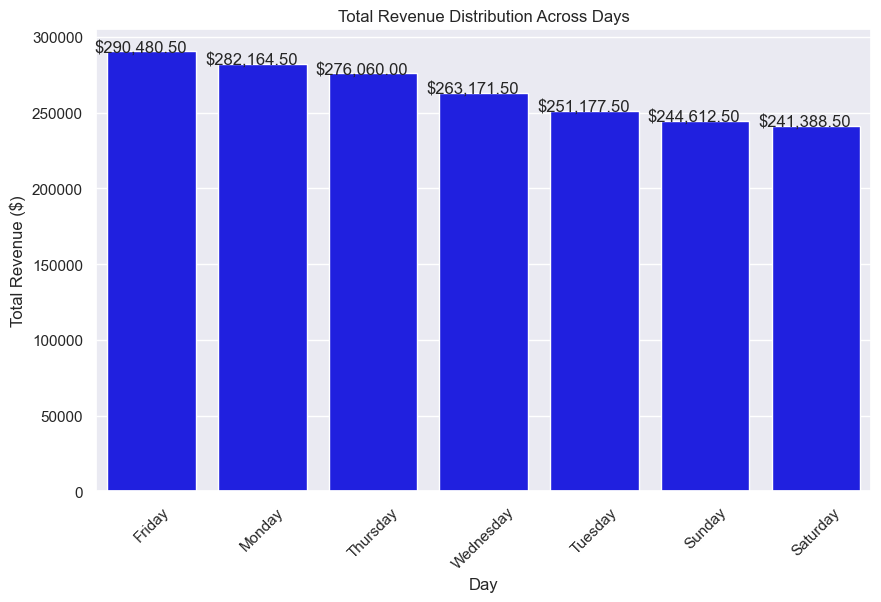

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping by 'day' and calculate total daily revenue
total_daily_revenue = df.groupby('day')['daily_revenue'].sum()

# Sortting the total daily revenue from highest to lowest
sorted_revenue = total_daily_revenue.sort_values(ascending=False)

# Setting Seaborn style
sns.set_theme()

# Plotting the bar chart using Seaborn
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=sorted_revenue.index, y=sorted_revenue, color='blue')

# Adding revenue labels at the top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, 
             bar.get_height() + 10, f"${bar.get_height():,.2f}", ha='center')

plt.title('Total Revenue Distribution Across Days')
plt.xlabel('Day')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.show()


* The day with the **highest** total revenue is **Friday** with a total revenue of $290480.50
* The day with the **lowest** total revenue is **Saturday** with a total revenue of $241388.50


### Summary of Findings
1. **Problematic Bus Lines:** Identified 13 bus lines facing potential operational issues over weekends due to high costs compared to revenue.
2. **Lowest Revenue Bus Line:** Bus line 1 exhibited the lowest average weekly revenue from ticket sales, signaling a potential area for improvement.
3. **Revenue Trends Across Days:** Friday emerged as the most profitable day, while Saturday experienced the lowest revenue. 

### Recommendations
1. **Optimize Problematic Bus Lines:** Consider discontinuing or restructuring bus lines flagged as problematic to mitigate financial losses.
2. **Revenue Enhancement:** Explore strategies to increase revenue on weekends, especially on Saturdays, through promotional offers, route adjustments, or marketing campaigns.
3. **Efficiency Improvements:** Analyze operational processes to identify areas for cost reduction and efficiency enhancement, potentially reducing operational costs per route.

### Conclusion
In conclusion, this analysis of Metro Transport's bus line data found several opportunities to optimize operations. By addressing problematic and low-revenue routes and tailoring schedules to passenger demand, the company can improve profitability. The findings provide data-driven recommendations to guide decision making. Further analysis could examine seasonal trends and geographic demand.